In [17]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from utils.utils import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D,GlobalAveragePooling2D,Dense,Conv2D, Convolution2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import sklearn.metrics as metrics
import seaborn as sns
from keras_vggface.vggface import VGGFace

In [10]:
data_normal = load_data('../Augmentation Data',['Normal'])
data_symptoms = load_data('../Augmentation Data',['Symptoms'])

In [12]:
train_data = np.concatenate((np.array(data_normal),
                           np.array(data_symptoms)))
labels = np.concatenate((np.zeros(6000),np.ones(3600)))

## VGG Face

In [13]:
model = VGGFace(weights='vggface',
                        include_top=False,
                        input_shape=(200,200,3))

## Feature Extractor

In [14]:
def create_features(dataset,model):
    
    train_data = np.expand_dims(dataset,axis=0)
    train_data = np.vstack(train_data)
    features = model.predict(train_data)
    features_flatten = features.reshape((features.shape[0],6*6*512))
    
    return train_data, features, features_flatten
    

In [16]:
train_data, features, features_flatten = create_features(train_data,model)

## Train Test Split

In [18]:
X_train, X_valid, y_train,y_valid = train_test_split(features,labels,test_size=0.2,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.15,random_state=42)

## Model Training

In [25]:
checkpointer = ModelCheckpoint(filepath='cnn_best.hdf5',verbose=1,
                              save_best_only=True)

In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(6, 6, 512))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',padding="Same")) 
model.add(MaxPooling2D((2, 2)))



model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [27]:
model_history = model.fit(X_train,y_train,
                         epochs=100,
                         callbacks=[es,checkpointer],
                         verbose=2,
                         validation_data=(X_valid,y_valid))

Train on 6528 samples, validate on 1920 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.14259, saving model to ../model/cnn_best.hdf5
6528/6528 - 2s - loss: 0.5309 - acc: 0.8441 - val_loss: 0.1426 - val_acc: 0.9495
Epoch 2/100

Epoch 00002: val_loss improved from 0.14259 to 0.10413, saving model to ../model/cnn_best.hdf5
6528/6528 - 1s - loss: 0.1640 - acc: 0.9350 - val_loss: 0.1041 - val_acc: 0.9552
Epoch 3/100

Epoch 00003: val_loss improved from 0.10413 to 0.09041, saving model to ../model/cnn_best.hdf5
6528/6528 - 1s - loss: 0.0935 - acc: 0.9623 - val_loss: 0.0904 - val_acc: 0.9661
Epoch 4/100

Epoch 00004: val_loss improved from 0.09041 to 0.08723, saving model to ../model/cnn_best.hdf5
6528/6528 - 1s - loss: 0.0677 - acc: 0.9776 - val_loss: 0.0872 - val_acc: 0.9682
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.08723
6528/6528 - 1s - loss: 0.0544 - acc: 0.9830 - val_loss: 0.0961 - val_acc: 0.9745
Epoch 6/100

Epoch 00006: val_loss did not improve from

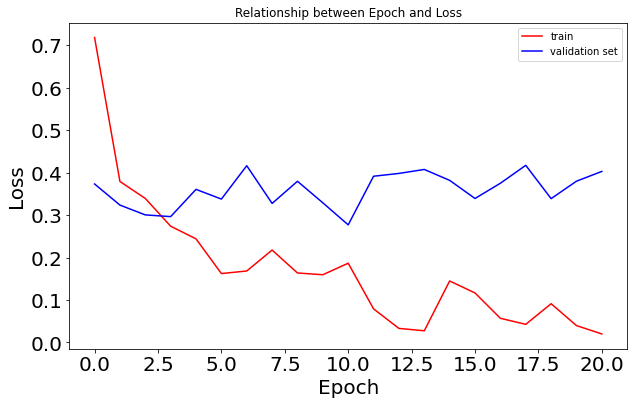

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='validation set')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.set_title('Relationship between Epoch and Loss')
ax.legend()
ax.tick_params(labelsize=20)

## Evaluate

In [30]:
print(model.evaluate(X_test,y_test))
predictions_ = model.predict(X_test)

1152/1152 [==============================] - 0s 82us/sample - loss: 0.1565 - acc: 0.9826
[0.15652594698876562, 0.9826389]


In [31]:
predictions = np.argmax(predictions_, axis=1)

print(classification_report(y_test,predictions))
print("Accuracy:",accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       718
         1.0       0.98      0.97      0.98       434

    accuracy                           0.98      1152
   macro avg       0.98      0.98      0.98      1152
weighted avg       0.98      0.98      0.98      1152

Accuracy: 0.9826388888888888


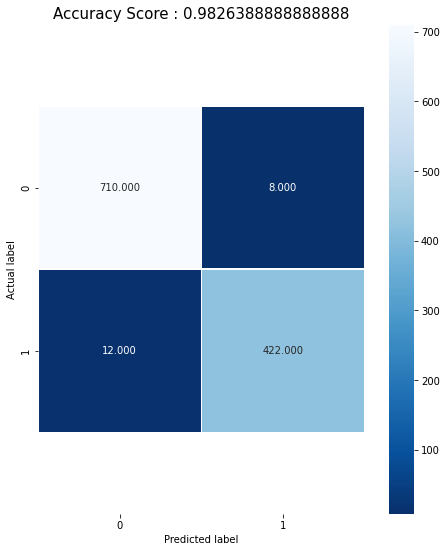

In [37]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

cm = metrics.confusion_matrix(y_test, predictions)
score = accuracy_score(y_test,predictions)

plt.figure(figsize=(9,9))
ax = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, 
                 square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score : {0}'.format(score)
plt.title(all_sample_title, size=15)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

## Load Model

In [49]:
model = tf.keras.models.load_model('../model/cnn_best.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
